# Importing Package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline  

from scipy import stats
from sklearn import preprocessing
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')
SEED = 42

In [2]:
# Reading Data
df = pd.read_csv('../input/stock-price-prediction-with-rnn/stock_data.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


In [4]:
# Input data stats
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,19586.000000,19586.000000,19586.000000,19586.000000,1.958600e+04,19586.0
mean,37.408582,37.881571,36.906405,37.406667,8.100395e+07,0.0
std,59.492049,60.287797,58.622548,59.480058,7.982366e+07,0.0
min,0.067200,0.067200,0.067200,0.067200,0.000000e+00,0.0
25%,1.412300,1.440600,1.384100,1.412300,3.385552e+07,0.0
50%,19.649500,19.933000,19.363000,19.640000,6.294731e+07,0.0
75%,38.605000,39.075750,38.229250,38.655500,1.010604e+08,0.0
max,386.690000,389.610000,379.345000,385.000000,2.069770e+09,0.0


In [5]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'Stock'], dtype='object')

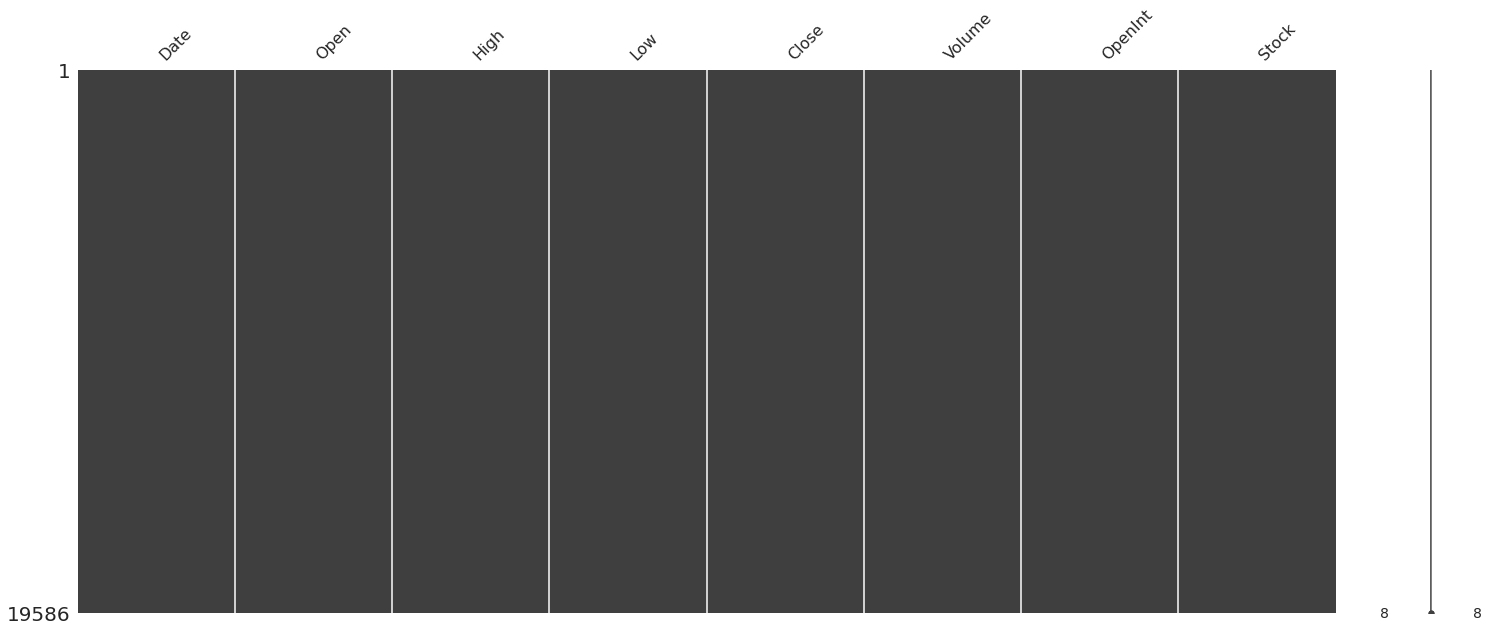

In [6]:
# Visualize the general missing values of data
msno.matrix(df)
plt.show()

In [7]:
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
Stock      0
dtype: int64

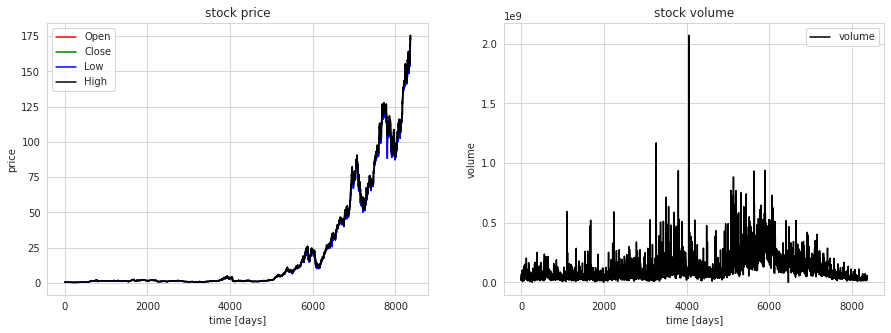

In [8]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.Stock == 'AAPL'].Open.values, color='red', label='Open')
plt.plot(df[df.Stock == 'AAPL'].Close.values, color='green', label='Close')
plt.plot(df[df.Stock == 'AAPL'].Low.values, color='blue', label='Low')
plt.plot(df[df.Stock == 'AAPL'].High.values, color='black', label='High')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.Stock == 'AAPL'].Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# Scatterplot for related data

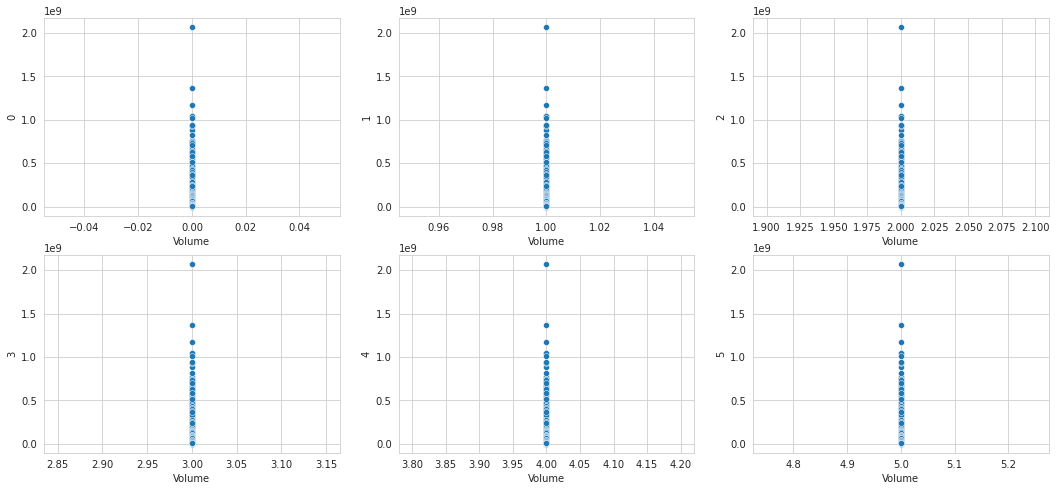

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

axs = axs.flatten()
for i, col in enumerate(list(df.index[:6])):
    sns.scatterplot(y='Volume', x=col, ax=axs[i], data=df)
    axs[i].set_xlabel('Volume')
    axs[i].set_ylabel(col)
plt.show()

# Data Split

In [10]:
X=df[['Open','High','Low']]
y=df['Close']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

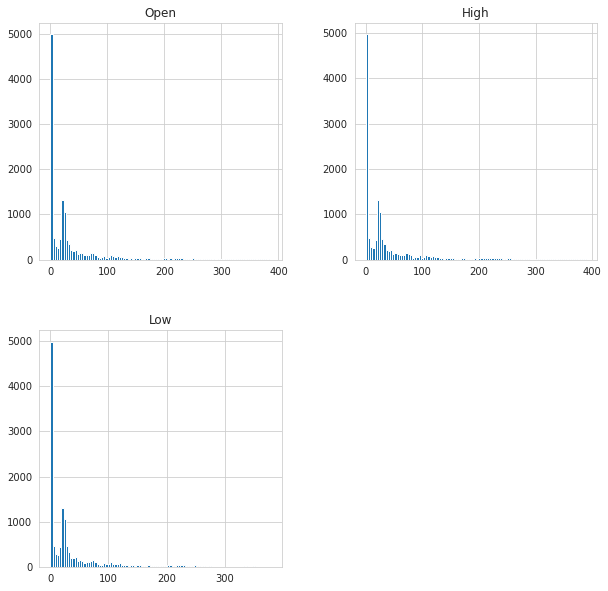

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
X_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Open')
ax1.set_xlabel('Close')

plt.show()

# Base model Creation

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time
SEED = 42

## Function creation for model validations

In [15]:
# Repeated K-fold cross validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Return root mean square error of model prediction (Used for test prediction)
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Return root mean square error applied cross validation (Used for training prediction)
def evaluate_model_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

# Multimodel creations

In [16]:
def Creating_models():
    # Initialize parameters for models
    alphas_ridge = [0.005, 0.01, 0.1, 1, 5, 10, 15]
    alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    e_alphas_elas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio_elas = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
    
    # Constructing the models
    models = dict()
    #Ridge is regression model applying l2 regularization technique
    models['ridge'] = RidgeCV(alphas=alphas_ridge, cv=kfolds)
    #Lasso stands for Least Absolute Shrinkage 
    models['lasso'] = LassoCV(alphas=alphas_lasso, random_state=SEED, cv=kfolds)
    #elasticnet is a penalized linear regression model that includes both the L1 and L2 penalties during training
    models['elasticnet'] = ElasticNetCV(alphas=e_alphas_elas, cv=kfolds, l1_ratio=e_l1ratio_elas)
    models['svr'] = SVR(C = 20, epsilon = 0.008, gamma =0.0003)
    models['gbr'] = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10, 
                                              loss='huber',random_state =SEED)
    #lgbm is a fast, distributed, high-performance gradient boosting framework that uses a tree-based learning algorithm
    models['lgbm'] = LGBMRegressor(objective='regression', num_leaves=4,
                                   learning_rate=0.01, n_estimators=5000,
                                   max_bin=200, bagging_fraction=0.75,
                                   bagging_freq=5, bagging_seed=7,
                                   feature_fraction=0.2,
                                   feature_fraction_seed=7, verbose=-1,
                                  colsample_bytree=None, subsample=None, subsample_freq=None)
    models['xgboost'] = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7, verbosity = 0,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=SEED, reg_alpha=0.00006)
    return models

# create the set of model
models = Creating_models()

# Train and test with data

In [17]:
from yellowbrick.regressor import ResidualsPlot

ridge's rmse after training: 0.5697901161442734
Computational runtime of this algo: 1.04 seconds



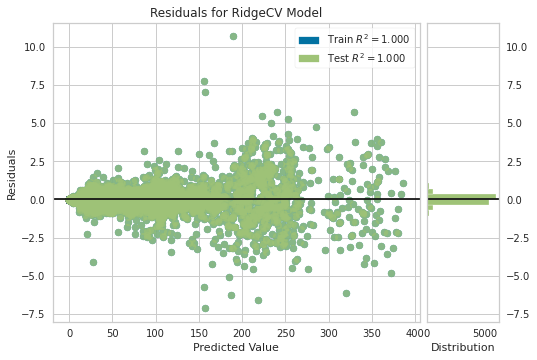

lasso's rmse after training: 1.0653253710276687
Computational runtime of this algo: 0.9 seconds



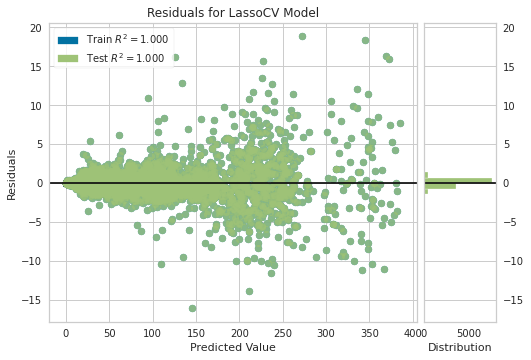

elasticnet's rmse after training: 1.0653227609999345
Computational runtime of this algo: 1.5 seconds



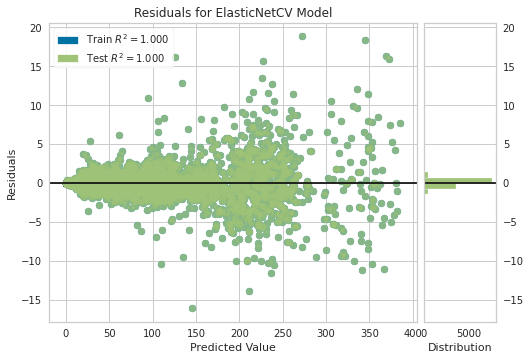

svr's rmse after training: 0.5856566427534331
Computational runtime of this algo: 51.85 seconds



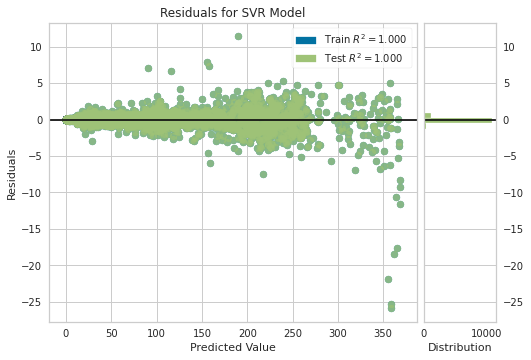

gbr's rmse after training: 0.8460081969703255
Computational runtime of this algo: 83.57 seconds



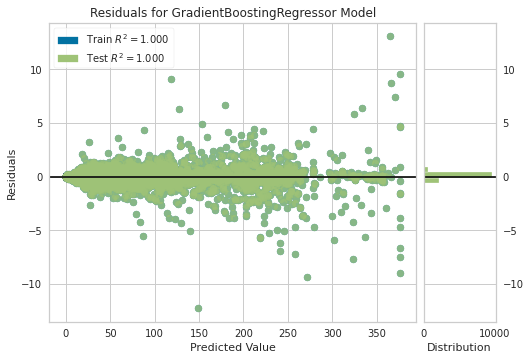

lgbm's rmse after training: 1.7597254824546376
Computational runtime of this algo: 11.95 seconds



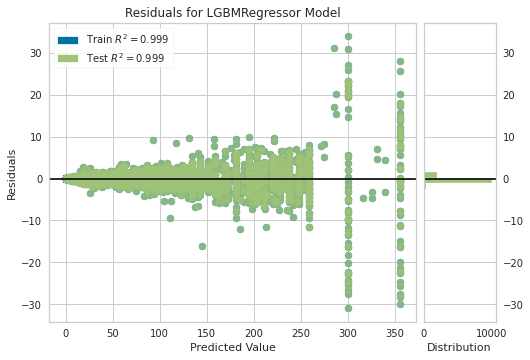

xgboost's rmse after training: 0.6893820259407684
Computational runtime of this algo: 27.1 seconds



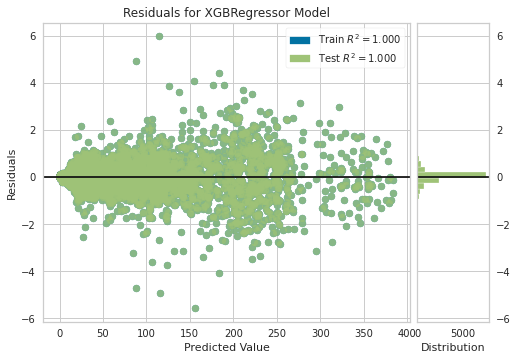

In [18]:
for name, model in models.items():
    # Start counting time
    start = time.perf_counter()
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_train, y_train)
    model = model.fit(X_train,y_train)
    rmse_result = rmse(y_test, model.predict(X_test))
    print(f'{name}\'s rmse after training: {rmse_result}')
    # Compute time for executing each algo
    run = time.perf_counter() - start
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')
    visualizer.show()

# Stacking models

## Stacking model Type 1 
In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than the learning algorithm alone. Stacking model is an ensemble one
It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.

In [19]:

stack_model = StackingCVRegressor(regressors=(models['ridge'], models['lasso'], models['xgboost'],
                                              models['elasticnet'], models['gbr'], models['lgbm']),
                                  meta_regressor=models['xgboost'], use_features_in_secondary=True)

In [20]:
start = time.perf_counter()

stack_model = stack_model.fit(X_train,y_train)
print('Finish training')
# Compute rmse without cross-validation technique
y_pred=stack_model.predict(X_test)
rmse_stack = rmse(y_test, stack_model.predict(X_test))
print(f'stack_model\'s rmse (using cv) after training: {rmse_stack}')

# Compute time for executing each algo
run = time.perf_counter() - start
print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

Finish training
stack_model's rmse (using cv) after training: 0.6323200669019993
Computational runtime of this algo: 312.64 seconds



## Blending model Type 2
Blending is an ensemble machine learning technique that uses a machine learning model to learn how to best combine the predictions from multiple contributing ensemble member models

In [21]:
def blend_models_predict(X):
    return ((0.05 * models['ridge'].predict(np.array(X))) + \
            (0.05 * models['lasso'].predict(np.array(X))) + \
            (0.05 * models['elasticnet'].predict(np.array(X))) + \
            (0.15 * models['gbr'].predict(np.array(X))) + \
            (0.15 * models['lgbm'].predict(np.array(X))) + \
            (0.25 * models['xgboost'].predict(np.array(X))) + \
            (0.3 * stack_model.predict(np.array(X))))
print('RMSLE score on train data:')
print(rmse(y_test, blend_models_predict(X_test)))

RMSLE score on train data:
0.7018920280623643


In [22]:
y_pred

array([331.62137  ,  73.605446 ,  21.854052 , ...,   1.327311 ,
         5.599839 ,   1.4669979], dtype=float32)

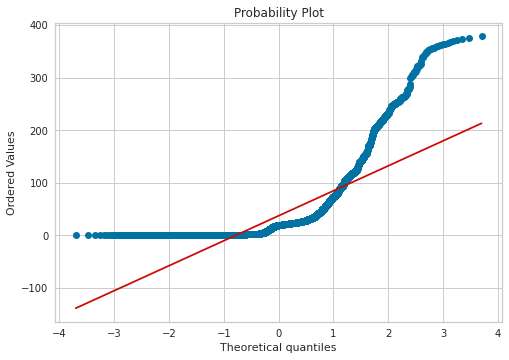

In [23]:
fig = plt.figure()
res = stats.probplot(y_pred, plot=plt)
plt.show()

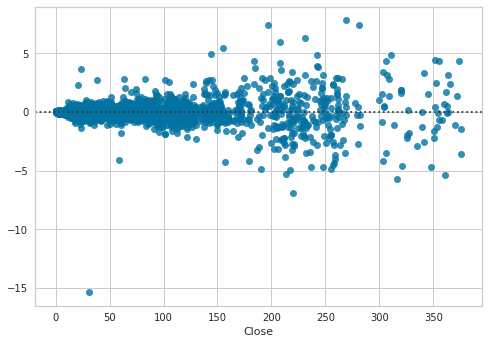

In [24]:
# Actual and predicted data 
import seaborn
seaborn.residplot(y_test, y_pred)
plt.savefig("out.png")

In [25]:
# Dataset
#https://www.kaggle.com/datasets/sanamps/stock-price-prediction-with-rnn

# LSTM Method

## function for min-max normalization of stock

In [27]:

def Normalize(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

## Data Split

In [28]:
def Train_test_splt(stock, seq_len):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


## Selecting Apple Stock for Calculation

In [35]:
import tensorflow as tf
import warnings
import sklearn.preprocessing
import sklearn
import datetime
import warnings
warnings.filterwarnings("ignore")

valid_set_size_percentage = 10 
test_set_size_percentage = 10

df_stock = df[df.Stock == 'AAPL'].copy()
df_stock.drop(['Stock'],1,inplace=True)
df_stock.drop(['Volume'],1,inplace=True)
df_stock.drop(['Date'],1,inplace=True)
cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = Normalize(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = Train_test_splt(df_stock_norm, seq_len)


df_stock.columns.values =  ['Open', 'High', 'Low', 'Close', 'OpenInt']


# RNN - LSTM


In [36]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]


In [37]:
import tensorflow as tf
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)


# parameters
n_steps = seq_len-1 
n_inputs = 9 
n_neurons = 200 
n_outputs = 9
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.compat.v1.reset_default_graph()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])
import tensorflow as tf
layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, 
                                  activation=tf.nn.leaky_relu, use_peepholes = True)
          for layer in range(n_layers)]

                                                                     
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              

In [38]:
# run graph
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

2022-12-05 12:47:47.218605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:47:47.219671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:47:47.220919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:47:47.221781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:47:47.222513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

0.00 epochs: MSE train/valid = 44.798557/2099.235107
5.00 epochs: MSE train/valid = 0.053445/26.814714
9.99 epochs: MSE train/valid = 0.039312/95.341362
14.99 epochs: MSE train/valid = 0.052168/64.121704
19.98 epochs: MSE train/valid = 0.022340/14.594740
24.98 epochs: MSE train/valid = 0.027416/12.647528
29.97 epochs: MSE train/valid = 0.041552/6.020057
34.97 epochs: MSE train/valid = 0.023561/7.526330
39.96 epochs: MSE train/valid = 0.024027/4.011117
44.96 epochs: MSE train/valid = 0.017699/3.036288
49.96 epochs: MSE train/valid = 0.017336/4.680547
54.95 epochs: MSE train/valid = 0.018403/1.310483
59.95 epochs: MSE train/valid = 0.021522/1.275725
64.94 epochs: MSE train/valid = 0.017280/3.766037
69.94 epochs: MSE train/valid = 0.024442/1.557838
74.93 epochs: MSE train/valid = 0.014563/2.792483
79.93 epochs: MSE train/valid = 0.019979/2.575496
84.92 epochs: MSE train/valid = 0.024672/1.679560
89.92 epochs: MSE train/valid = 0.017246/1.434639
94.91 epochs: MSE train/valid = 0.015162/2.2

correct sign prediction for close - open price for train/valid/test: 0.92/0.92/0.79


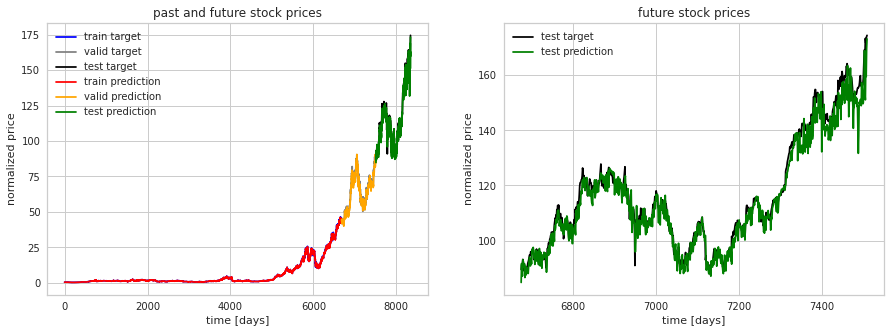

In [39]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))